# Домашнее задание по сопряженным градиентам

##### Выполнил: ЖЕНЯ ЛАГУТИН

В этом задании Вам предлагается рассмотреть как влияют предобуславливатели на время работы метода сопряженных градиентов.

Рассмотрим задачу минимизации квадратичной формы:

$$f(x) = \frac{1}{2}||Ax-b||^2_2=\frac{1}{2}\sum\limits_{i=1}^n(a_i^Tx-b_i)^2$$

где $A\in \mathbb{S}^{n}_{++}$, $b \in \mathbb{R}^{n}$.

Как мы знаем, эта задача выпукла и минимум находится из условия $\nabla f(x^*) =Ax^*-b= 0$. То есть для решения задачи необходимо разрешить систему уравнений $Ax=b$. Можно просто применить метод сопряженных градиентов, но если матрица плохо обусловлена ($\frac{\lambda_{max}}{\lambda_{min}}>>1$), метод работает очень медленно. Один из способов борьбы с этим - использование матриц-предобуславливателей разных видов и последующее решение одной из задач:

$$M^{-1}A x = M^{-1}b$$

$$M^TAM y = M^Tb$$ где $y = M^{-1}x.$

Существует несколько довольно простых, но зачастую сильно улучшающих работу метода **предоубславливателей**:


* M = diag($A_{11},A_{22}...A_{nn}$) (Jacobi)

* M $\approx \hat A$, где например $\hat A$ - неполная [факторизация](http://www.math.iit.edu/~fass/477577_Chapter_16.pdf) Холецкого


Факторизация Холецкого s.p.d. матрицы A - ее разложение на произведение нижнетреугольной и верхнетреугольной матрицы: $A = L^TL$ [wiki](https://en.wikipedia.org/wiki/Cholesky_decomposition).  Есть несколько упрощений этого алгоритма, позволяющих получить матрицу, "похожую" на A. Мы будем использовать следующую:  $if \quad (a_{i,j} =0) \rightarrow l_{i,j} = 0$, а далее по алгоритму.

$\textbf{Задание}$ Выбрать 1 задачу [отсюда](https://sparse.tamu.edu/), исследовать как влияет на скорость сходимости тот или иной предоубславливатель:

1) Сравнить число итераций, за которое метод сходится с точностью $10^{-7}$ для двух предобуславливателей и для обычного метода сопряженных градиентов.

2) Построить графики зависимости ошибки $\dfrac{x_{k-1}-x_{k}}{x_k}$ от номера итерации для двух предобуславливателей и для обычного метода сопряженных градиентов.

Пример:

![alt text](https://pp.userapi.com/c831309/v831309597/108727/JXO7HGHv8r4.jpg)

In [127]:
import scipy.io
import numpy as np
from matplotlib import pyplot as plt
import pandas

In [128]:
mat = scipy.io.loadmat('bcsstk27.mat')
#mat = scipy.io.loadmat('msc01440.mat')
A = mat['Problem'][0][0][1]
AA = scipy.sparse.csc_matrix(A)
A = AA.todense()
A = np.array(A)

In [129]:
mat['Problem']

array([[(array(['STIFFNESS MATRIX BUCKLING PROBLEM (ANDY MERA)'], dtype='<U45'), <1224x1224 sparse matrix of type '<class 'numpy.float64'>'
	with 56126 stored elements in Compressed Sparse Column format>, array(['HB/bcsstk27'], dtype='<U11'), array([[49]], dtype=uint8), array(['1984'], dtype='<U4'), array(['A. Mera, R. Cigel, J. Lewis'], dtype='<U27'), array(['I. Duff, R. Grimes, J. Lewis'], dtype='<U28'), array(['structural problem'], dtype='<U18'))]],
      dtype=[('title', 'O'), ('A', 'O'), ('name', 'O'), ('id', 'O'), ('date', 'O'), ('author', 'O'), ('ed', 'O'), ('kind', 'O')])

In [130]:
def transform1(A, b, M):
    M_inv = np.linalg.inv(M)
    A_ = M_inv @ A
    b_ = M_inv @ b
    return A_, b_

def transform2(A, b, M):
    A_ = M.transpose() @ A @ M
    b_ = M.transpose() @ b
    return A_, b_

def jacobi_precond(A):
    return np.diag(np.diag(A))

def incompl_cholevsky_factor(A):
    n = A.shape[0]
    L = np.zeros(A.shape)
    for j in range(n):
        if A[j, j] != 0:
            L[j, j] = np.sqrt(A[j, j] - sum(L[j, :j]**2))                            
        else:
            L[i, j] = 0
        for i in range(j+1, n):
            if A[i, j] != 0:
                L[i, j] = (A[i, j] - sum(L[i] * L[j])) / L[j, j]
            else:
                L[i, j] = 0
    return L

def cholevsky_precond(A):
    L = incompl_cholevsky_factor(A)
    M = L @ L.transpose()
    return M
    
def gauss_seidel_precond(A):
    return np.tril(A)

def SSOR_precond(A, w=1.5):
    D = np.diag(np.diag(A))
    L = np.tril(A)
    return 2 / (w * (2-w)) *(D + w * L) * np.linalg.inv(D) * (D + w * L.transpose())

In [158]:
def conj_grad(A, b, x0, loss=None, eps=1e-7):
    # f(x) = 0.5 x^t A x + b^t x, A \in S++(R^n)
    # \nabla f(x) = Ax + b
    s = A @ x0 + b                  # s = Ax+b = \nabla f(x)
    d = -s                          # d0 = -\nabla f(x0)
    x = [x0]
    k = 0
    n = x0.shape[0]
    flag1 = 0
    flag2 = 0
    if loss is None:
        loss = lambda x: np.linalg.norm(A @ x + b)
    losses = [loss(x0)]
    n_loss = n
    n_conv = n
    while k < n or flag1 == 0 or flag2 == 0:
        if flag1 == 0:
            if k > 0 and (np.linalg.norm(x[-1]-x[-2])) / np.linalg.norm(x[-2]) < eps:
                flag1 = 1
                n_conv = k
        if flag2 == 0:
            if  sum(losses[-min(k,1):]) < eps*1:
                flag2 = 1
                n_loss = k
        p = d.transpose() @ A @ d         # p = d^t A d
        #if (p < 1e-5):
        #    p = 1e-4
        alpha = -d.transpose() @ s / p    # a = -d^t(Ax+b) / (d^t A d)
        x.append(x[-1] + alpha * d)       # x_{i+1} = x_i + a*d
        k = k + 1
        s = A @ x[-1] + b
        beta = s.transpose() @ A @ d / p  # beta = \nabla f(x_{i+1})^t A d / (d^t A d)
        d = -s + beta * d                 # d_{i+1} = -\nabla f(x_{i+1}) + b*d
        losses.append(loss(x[-1]))
        #print(losses[-1]) # loss = ||s||
    return x, losses, n_conv, n_loss

In [159]:
b = np.random.randn(A.shape[0]) * np.mean(A)
x0 = np.random.rand(A.shape[0]) * np.mean(A)
losses = {}
x = {}
n_loss = {}
n_conv = {}
preconditioners = ['jacobi', 'choletsky', 'gauss-seidel', 'no preconditioner', 'SSOR (w=1.5)', 'SSOR (w=0.5)']
A_ = {}
b_ = {}
M = {}
for precond in preconditioners:
    loss = None
    if precond == 'jacobi':
        M[precond] = jacobi_precond(A)
        #loss = lambda x: np.linalg.norm(A @ M @ x + b_['jacobi'])
    elif precond == 'choletsky':
        M[precond] = cholevsky_precond(A)
        #loss = lambda x: M @ (A @ x + b)
    elif precond == 'gauss-seidel':
        M[precond] = gauss_seidel_precond(A)
    elif precond == 'SSOR (w=1.5)':
        M[precond] = SSOR_precond(A)
    elif precond == 'SSOR (w=0.5)':
        M[precond] = SSOR_precond(A, w=0.5)
    else:
        M[precond] = np.eye(A.shape[0])
    A_[precond], b_[precond] = transform1(A, b, M[precond])
    x[precond], losses[precond], n_conv[precond], n_loss[precond] = conj_grad(A_[precond], -b_[precond], x0, loss)

In [160]:
print('Dimension of A: ', A.shape[0])

data = []
for precond in preconditioners:
    data.append([precond, n_iter[precond], np.round(losses[precond][n_loss[precond]], 10)]) 
sort_f = lambda x: x[1]
data.sort(key=sort_f)
df = pandas.DataFrame(np.array(data), columns=['Method', 'Iterations until convergence', 'Loss'])
df['Loss'] = df['Loss'].map(float)
df

Dimension of A:  1224


,Method,Iterations until convergence,Loss
0,choletsky,35,8.970000e-08
1,SSOR (w=1.5),462,9.850000e-08
2,SSOR (w=0.5),490,8.650000e-08
3,jacobi,538,9.920000e-08
4,gauss-seidel,993,9.980000e-08
5,no preconditioner,1224,9.800000e-08


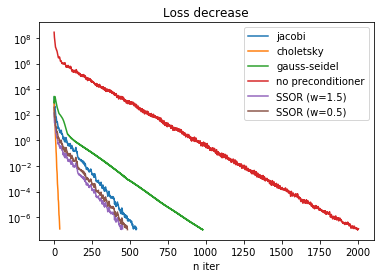

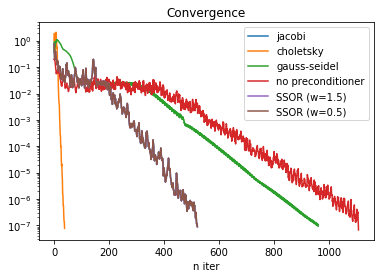

In [161]:
for precond in preconditioners:
    trend  = losses[precond][:n_loss[precond]]
    plt.plot(trend, label=precond)
    plt.yscale('log')
    plt.legend()
    plt.xlabel('n iter')
    plt.title('Loss decrease')
plt.show()
for precond in preconditioners:
    x_ = np.array(x[precond]) 
    conv = np.linalg.norm(x_[:-1] - x_[1:], axis=1) / np.linalg.norm(x_[1:], axis=1)
    plt.plot(conv[:n_conv[precond]], label=precond)
    plt.yscale('log')
    plt.legend()
    plt.xlabel('n iter')
    plt.title('Convergence')
plt.show()